In [1]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [3]:
NUM_CLASSES = 16

# 学習データ読み込み

In [4]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [5]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [8]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 20)                860       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 16)                176       
                                                                 
Total params: 1,246
Trainable params: 1,246
Non-trainable params: 0
_________________________________________________________________


In [9]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [10]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [11]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
40/63 [==================>...........] - ETA: 0s - loss: 2.7237 - accuracy: 0.1127
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
63/63 [==============================] - 3s 9ms/step - loss: 2.6887 - accuracy: 0.1284 - val_loss: 2.5446 - val_accuracy: 0.1761
Epoch 2/1000
50/63 [======================>.......] - ETA: 0s - loss: 2.5138 - accuracy: 0.1780
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
63/63 [==============================] - 0s 5ms/step - loss: 2.4914 - accuracy: 0.1862 - val_loss: 2.3020 - val_accuracy: 0.2467
Epoch 3/1000
51/63 [=======================>......] - ETA: 0s - loss: 2.3058 - accuracy: 0.2400
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
63/63 [==============================] - 0s 4ms/step - loss: 2.2933 - accuracy: 0.2400 - val_loss: 2.0872 - val_accuracy: 0.2843
Epoch 4/1000
49/63 [======================>.......] - ETA: 0s - loss: 2.1459 - accuracy: 0.2683
E

In [12]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

21/21 [==============================] - 0s 1ms/step - loss: 0.3997 - accuracy: 0.8934


In [13]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [14]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 111ms/step
[1.3398179e-01 5.2188289e-01 3.4404007e-01 2.9974757e-20 9.5188203e-05
 1.1710786e-26 6.5040448e-21 6.9375779e-23 2.5519650e-33 9.6524631e-32
 0.0000000e+00 2.2391632e-28 3.8472755e-14 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
1


# 混同行列

84/84 [==============================] - 0s 1ms/step


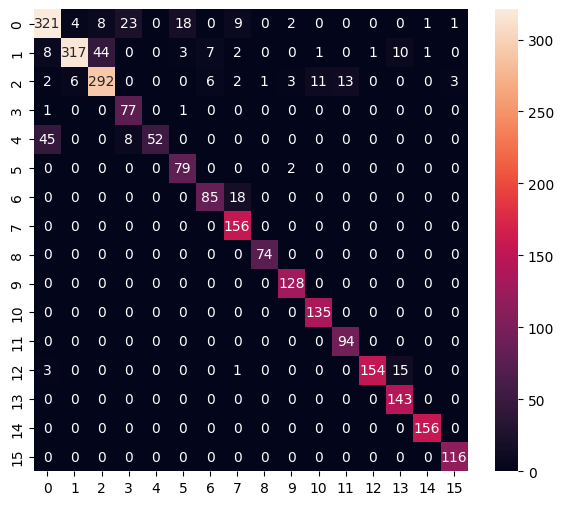

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.83      0.84       387
           1       0.97      0.80      0.88       394
           2       0.85      0.86      0.86       339
           3       0.71      0.97      0.82        79
           4       1.00      0.50      0.66       105
           5       0.78      0.98      0.87        81
           6       0.87      0.83      0.85       103
           7       0.83      1.00      0.91       156
           8       0.99      1.00      0.99        74
           9       0.95      1.00      0.97       128
          10       0.92      1.00      0.96       135
          11       0.88      1.00      0.94        94
          12       0.99      0.89      0.94       173
          13       0.85      1.00      0.92       143
          14       0.99      1.00      0.99       156
          15       0.97      1.00      0.98       116

    accuracy                           0.89      2663
   m

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [16]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [17]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\ronil\AppData\Local\Temp\tmp1pz269pl\assets


INFO:tensorflow:Assets written to: C:\Users\ronil\AppData\Local\Temp\tmp1pz269pl\assets


7072

# 推論テスト

In [18]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [19]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [20]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [21]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [22]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.3398139e-01 5.2188236e-01 3.4404105e-01 2.9974722e-20 9.5187919e-05
 1.1710773e-26 6.5040630e-21 6.9375710e-23 2.5519624e-33 9.6525272e-32
 0.0000000e+00 2.2391950e-28 3.8472792e-14 0.0000000e+00 0.0000000e+00
 0.0000000e+00]
1
